In [11]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

In [17]:
def load_and_analyze_dataset(file_path, dataset_name):
    print(f"Анализ датасета: {dataset_name}")
    print(f"Файл: {file_path}")
    
    df = pd.read_csv(file_path)

    print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print("\nПервые 5 строк:")
    print(df.head())
    
    print("\nИнформация о типах данных:")
    print(df.info())
    
    print("\nБазовая статистика:")
    print(df.describe())
    
    missing = df.isnull().sum()
    if missing.any():
        print(f"\nПропуски найдены:")
        for col, count in missing[missing > 0].items():
            print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")
    else:
        print("\nПропуски: нет")
    
    X = df.drop('sample_id', axis=1)
    sample_ids = df['sample_id']
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"\nЧисловые признаки ({len(numeric_cols)}): {numeric_cols}")
    print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}")
    
    return df, X, sample_ids, numeric_cols, categorical_cols

In [18]:
def create_preprocessor(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    return preprocessor

In [19]:
def evaluate_kmeans(X, max_k=20, random_state=42):
    results = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)
        
        if len(np.unique(labels)) > 1:
            silhouette = silhouette_score(X, labels)
            db = davies_bouldin_score(X, labels)
            ch = calinski_harabasz_score(X, labels)
            inertia = kmeans.inertia_
        else:
            silhouette = np.nan
            db = np.nan
            ch = np.nan
            inertia = np.nan
            
        results.append({
            'k': k,
            'silhouette': silhouette,
            'davies_bouldin': db,
            'calinski_harabasz': ch,
            'inertia': inertia,
            'labels': labels
        })
    
    return pd.DataFrame(results)

In [20]:
def evaluate_dbscan(X, eps_range=np.linspace(0.1, 2.0, 20), min_samples_list=[2, 3, 5, 10]):
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_list:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_ratio = np.sum(labels == -1) / len(labels) if -1 in labels else 0
            
            if n_clusters > 1:
                non_noise_mask = labels != -1
                if np.sum(non_noise_mask) > 1 and len(np.unique(labels[non_noise_mask])) > 1:
                    X_non_noise = X[non_noise_mask]
                    labels_non_noise = labels[non_noise_mask]
                    
                    silhouette = silhouette_score(X_non_noise, labels_non_noise)
                    db = davies_bouldin_score(X_non_noise, labels_non_noise)
                    ch = calinski_harabasz_score(X_non_noise, labels_non_noise)
                else:
                    silhouette = np.nan
                    db = np.nan
                    ch = np.nan
            else:
                silhouette = np.nan
                db = np.nan
                ch = np.nan
                
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_ratio': noise_ratio,
                'silhouette': silhouette,
                'davies_bouldin': db,
                'calinski_harabasz': ch,
                'labels': labels
            })
    
    return pd.DataFrame(results)

In [21]:
def visualize_results(X, labels, title, save_path=None):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=labels, cmap='tab20', alpha=0.7, s=50)
    plt.colorbar(scatter, label='Кластер')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    return X_pca

In [22]:
def plot_metric_vs_k(kmeans_results, metric='silhouette', save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(kmeans_results['k'], kmeans_results[metric], 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Количество кластеров (k)', fontsize=12)
    plt.ylabel(metric.capitalize(), fontsize=12)
    plt.title(f'{metric.capitalize()} vs k для KMeans', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    best_k = kmeans_results.loc[kmeans_results[metric].idxmax(), 'k']
    best_value = kmeans_results[metric].max()
    plt.axvline(x=best_k, color='r', linestyle='--', alpha=0.7)
    plt.text(best_k + 0.2, best_value * 0.95, f'Лучшее k={best_k}', color='red')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

In [26]:
def plot_dbscan_metrics(dbscan_results, save_path=None):
    valid_results = dbscan_results.dropna(subset=['silhouette'])
    
    if len(valid_results) > 0:
        plt.figure(figsize=(10, 6))
        
        for min_samples in sorted(valid_results['min_samples'].unique()):
            subset = valid_results[valid_results['min_samples'] == min_samples].sort_values('eps')
            plt.plot(subset['eps'], subset['silhouette'], 
                    marker='o', linewidth=2, markersize=6, 
                    label=f'min_samples={min_samples}')
            
            best_idx = subset['silhouette'].idxmax()
            best_eps = subset.loc[best_idx, 'eps']
            best_silhouette = subset.loc[best_idx, 'silhouette']
            
            plt.scatter(best_eps, best_silhouette, s=100, 
                       color=plt.gca().lines[-1].get_color(), 
                       edgecolor='black', zorder=5)
        
        plt.xlabel('eps')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score для DBSCAN (разные min_samples)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')

Анализ датасета: Dataset 01 - Разные шкалы + шум
Файл: data/S07-hw-dataset-01.csv
Размер датасета: 12000 строк, 9 столбцов

Первые 5 строк:
   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  

Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 

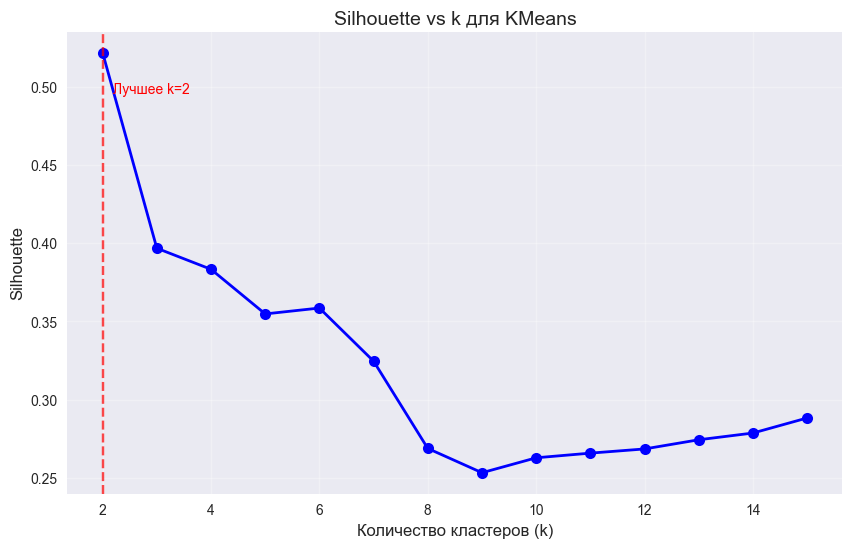

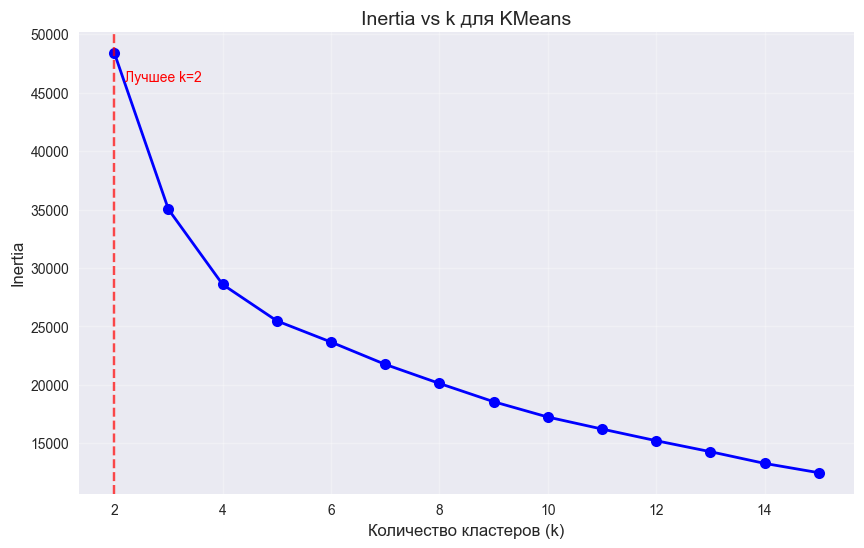

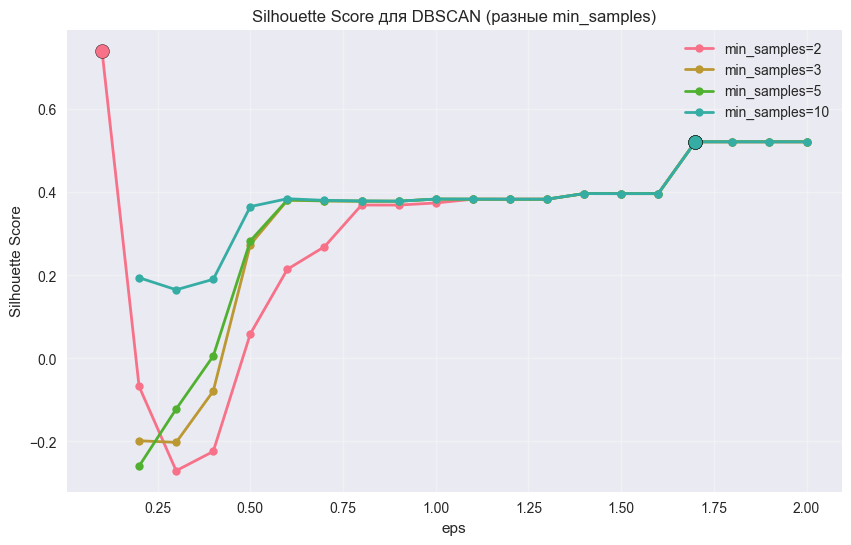

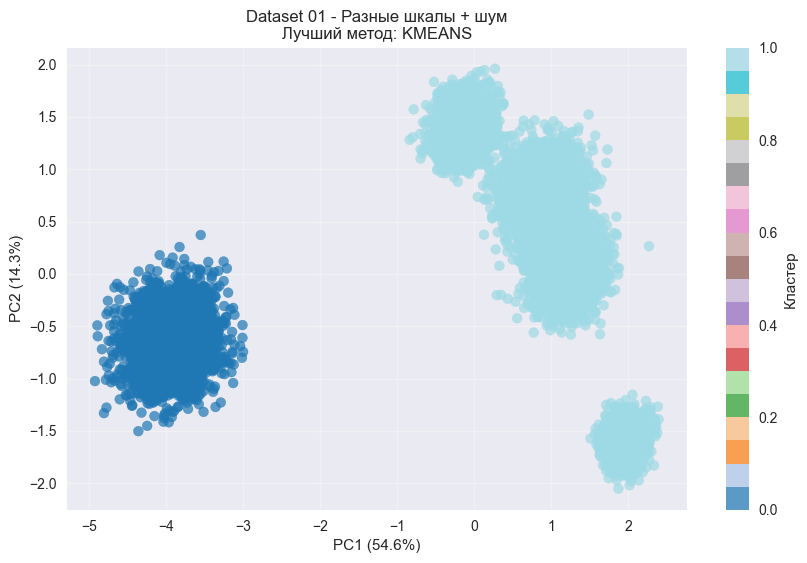

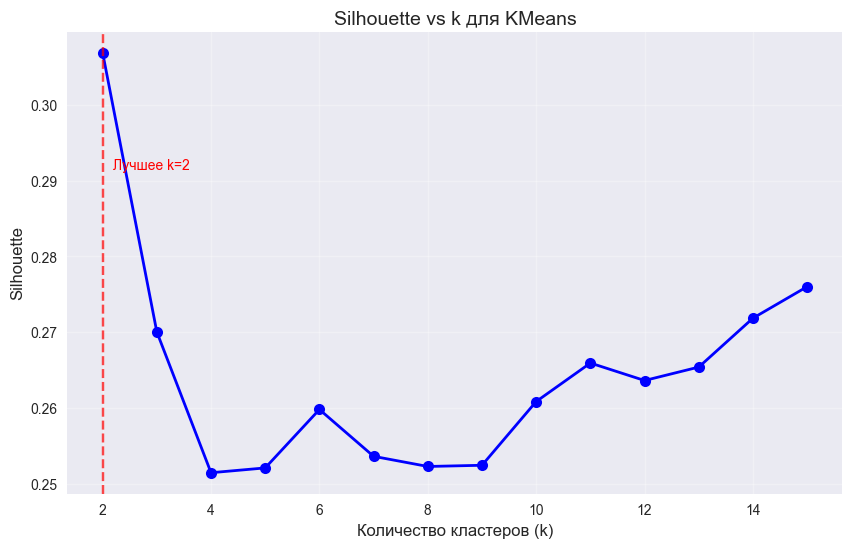

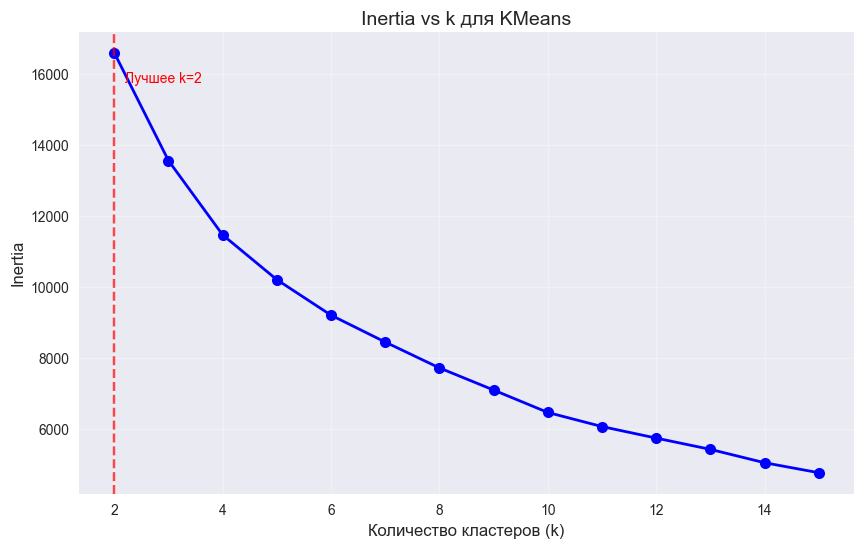

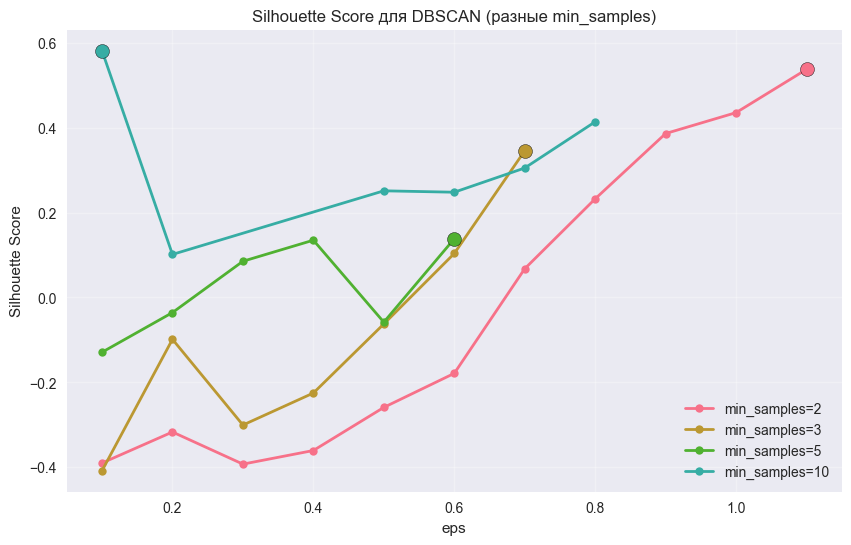

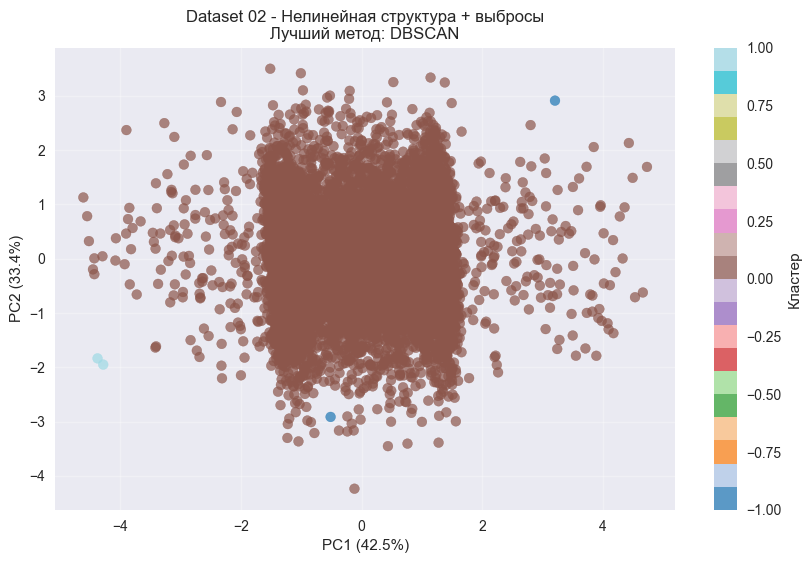

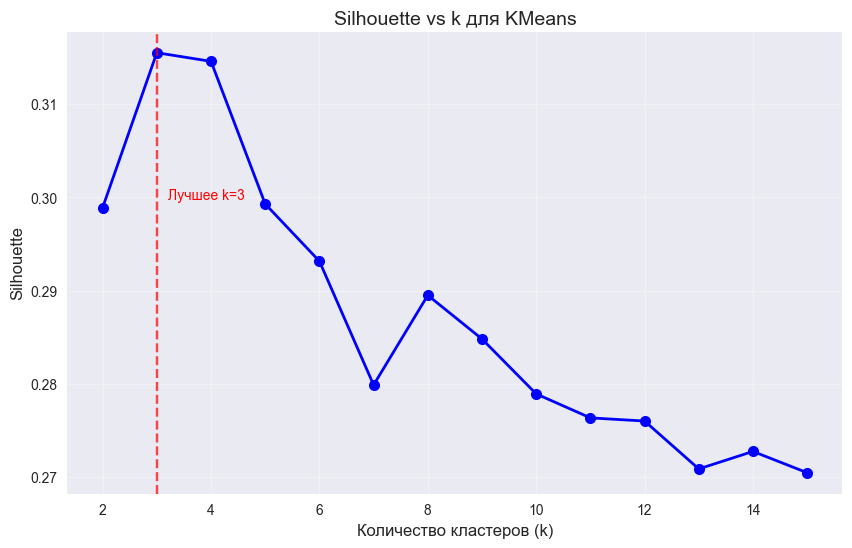

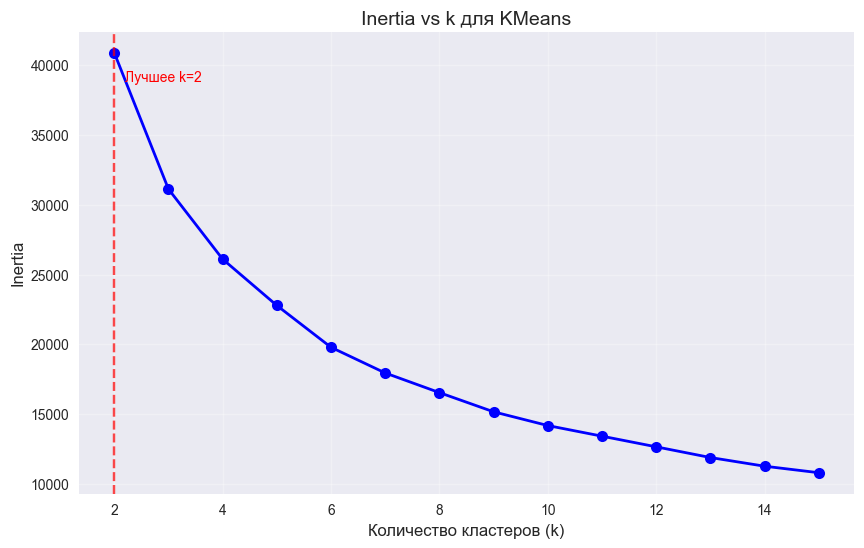

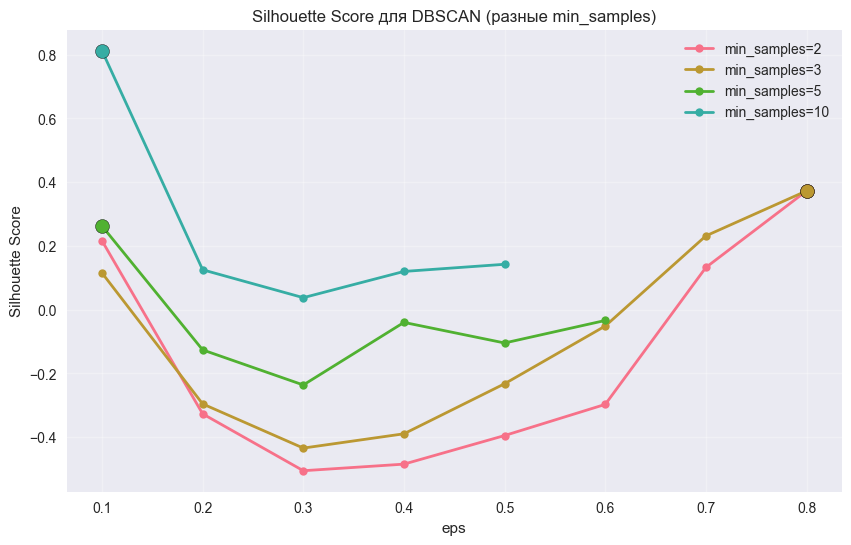

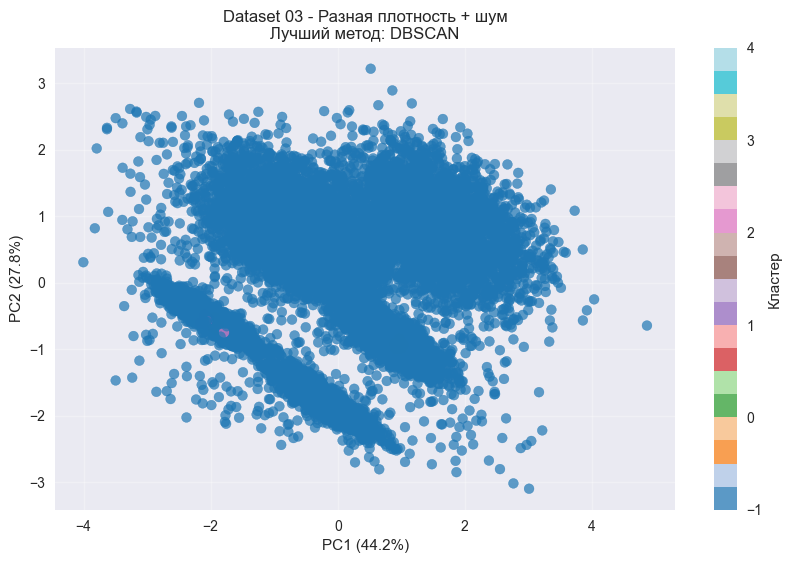

In [34]:
datasets_info = {
    'ds1': {
        'file': 'data/S07-hw-dataset-01.csv',
        'name': 'Dataset 01 - Разные шкалы + шум'
    },
    'ds2': {
        'file': 'data/S07-hw-dataset-02.csv', 
        'name': 'Dataset 02 - Нелинейная структура + выбросы'
    },
    'ds3': {
        'file': 'data/S07-hw-dataset-03.csv',
        'name': 'Dataset 03 - Разная плотность + шум'
    }
}

all_results = {}
best_configs = {}
final_labels = {}

for ds_key, ds_info in datasets_info.items():

    df, X, sample_ids, numeric_cols, categorical_cols = load_and_analyze_dataset(
        ds_info['file'], ds_info['name']
    )
    
    print(f"\nПРЕПРОЦЕССИНГ")
    
    preprocessor = create_preprocessor(numeric_cols, categorical_cols)
    X_processed = preprocessor.fit_transform(X)
    
    print(f"Размерность после препроцессинга: {X_processed.shape}")

    print(f"\nАНАЛИЗ KMEANS")

    kmeans_results = evaluate_kmeans(X_processed, max_k=15)

    plot_metric_vs_k(kmeans_results, 'silhouette',
                    f'artifacts/figures/{ds_key}_kmeans_silhouette.png')
    plot_metric_vs_k(kmeans_results, 'inertia',
                    f'artifacts/figures/{ds_key}_kmeans_inertia.png')
    
    print(f"\nАНАЛИЗ DBSCAN")

    dbscan_results = evaluate_dbscan(X_processed)
    
    plot_dbscan_metrics(dbscan_results,
                       f'artifacts/figures/{ds_key}_dbscan_metrics.png')
    
    all_results[ds_key] = {
        'kmeans': kmeans_results,
        'dbscan': dbscan_results,
        'X_processed': X_processed,
        'sample_ids': sample_ids
    }
    
    best_kmeans = kmeans_results.loc[kmeans_results['silhouette'].idxmax()]
    
    dbscan_valid = dbscan_results.dropna()
    if len(dbscan_valid) > 0:
        dbscan_filtered = dbscan_valid[(dbscan_valid['n_clusters'] >= 2) & 
                                      (dbscan_valid['n_clusters'] <= 10)]
        if len(dbscan_filtered) > 0:
            best_dbscan = dbscan_filtered.sort_values('silhouette', ascending=False).iloc[0]
        else:
            best_dbscan = dbscan_valid.sort_values('silhouette', ascending=False).iloc[0]
    else:
        best_dbscan = None
    
    print(f"\nЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    print(f"KMeans: k={best_kmeans['k']}, silhouette={best_kmeans['silhouette']:.3f}")
    
    if best_dbscan is not None:
        print(f"DBSCAN: eps={best_dbscan['eps']:.2f}, min_samples={best_dbscan['min_samples']}, "
              f"clusters={best_dbscan['n_clusters']}, noise={best_dbscan['noise_ratio']:.1%}, "
              f"silhouette={best_dbscan['silhouette']:.3f}")
    
    if best_dbscan is not None and best_dbscan['silhouette'] > best_kmeans['silhouette']:
        best_method = 'dbscan'
        best_result = best_dbscan
    else:
        best_method = 'kmeans'
        best_result = best_kmeans
    
    best_configs[ds_key] = {
        'method': best_method,
        'silhouette': float(best_result['silhouette']),
        'davies_bouldin': float(best_result['davies_bouldin']),
        'calinski_harabasz': float(best_result['calinski_harabasz'])
    }
    
    if best_method == 'kmeans':
        best_configs[ds_key]['params'] = {'k': int(best_result['k'])}
    else:
        best_configs[ds_key]['params'] = {
            'eps': float(best_result['eps']),
            'min_samples': int(best_result['min_samples'])
        }
        best_configs[ds_key]['noise_ratio'] = float(best_result['noise_ratio'])
        best_configs[ds_key]['n_clusters'] = int(best_result['n_clusters'])
    
    print(f"\nЛУЧШИЙ МЕТОД: {best_method.upper()}")
    
    X_pca = visualize_results(
        X_processed, 
        best_result['labels'],
        f"{ds_info['name']}\nЛучший метод: {best_method.upper()}",
        f'artifacts/figures/{ds_key}_best_clusters_pca.png'
    )
    
    final_labels[ds_key] = {
        'sample_id': sample_ids.values,
        'cluster_label': best_result['labels']
    }

Dataset 01: Оба алгоритма показали одинаковое качество (silhouette=0.522) с выделением 2 кластеров. DBSCAN не обнаружил шума. 
Разные шкалы признаков (f01-f08 варьируются от -200 до +200, f03 в диапазоне -1.6 до 0.5) - сложности, но масштабирование решило эту проблему. 
Дадасет имеет сферические кластеры примерно одинакового размера, что идеально для KMeans. Разные шкалы без масштабирования сломали бы алгоритм, 
но StandardScaler исправил это.

Dataset 02: DBSCAN значительно превзошел KMeans (0.537 vs 0.307). Выделено 2 кластера без шума. 
Наличие шумового признака z_noise и нелинейная структура данных - сложности. 
KMeans предполагает сферические кластеры, но здесь явная нелинейная структура. DBSCAN может находить кластеры произвольной формы и 
игнорировать z_noise как шумовой признак.

Dataset 03: DBSCAN показал исключительно высокий silhouette (0.812) против результата KMeans (0.316). 
Кластеры разной плотности и фоновый шум - сложности. 
KMeans не справляется с разной плотностью - пытается делить пространство на равные сферы. DBSCAN с правильно подобранными 
параметрами (eps=0.10, min_samples=10) смог выделить плотные ядра (5 кластеров), маркировав 99.6% точек как шум.

In [29]:
print(f"\nПроверка устойчивости")

X_processed_ds1 = all_results['ds1']['X_processed']
best_k_ds1 = best_configs['ds1']['params']['k']

ari_scores = []
labels_list = []

for i in range(5):
    random_state = 42 + i * 100
    kmeans = KMeans(n_clusters=best_k_ds1, 
                   random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X_processed_ds1)
    labels_list.append(labels)
    
    if i > 0:
        ari = adjusted_rand_score(labels_list[0], labels)
        ari_scores.append(ari)
        print(f"Запуск {i+1} (random_state={random_state}): ARI с первым запуском = {ari:.4f}")

print(f"\nСредний ARI: {np.mean(ari_scores):.4f}")
print(f"Стандартное отклонение ARI: {np.std(ari_scores):.4f}")


Проверка устойчивости
Запуск 2 (random_state=142): ARI с первым запуском = 1.0000
Запуск 3 (random_state=242): ARI с первым запуском = 1.0000
Запуск 4 (random_state=342): ARI с первым запуском = 1.0000
Запуск 5 (random_state=442): ARI с первым запуском = 1.0000

Средний ARI: 1.0000
Стандартное отклонение ARI: 0.0000


In [31]:
def cluster_analysis(labels, dataset_name):
    print(f"\nАнализ кластеров для {dataset_name}:")
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    print("Размеры кластеров:")
    for label, count in zip(unique_labels, counts):
        if label == -1:
            print(f"  Шум (кластер -1): {count} точек ({count/len(labels)*100:.1f}%)")
        else:
            print(f"  Кластер {label}: {count} точек ({count/len(labels)*100:.1f}%)")
    
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    print(f"Всего кластеров (без учета шума): {n_clusters}")
    
    if -1 in unique_labels:
        noise_ratio = counts[unique_labels == -1][0] / len(labels)
        print(f"Доля шума: {noise_ratio*100:.1f}%")
    
    return n_clusters

for ds_key, ds_info in datasets_info.items():
    if ds_key in final_labels:
        n_clusters = cluster_analysis(
            final_labels[ds_key]['cluster_label'], 
            ds_info['name']
        )
        print()


Анализ кластеров для Dataset 01 - Разные шкалы + шум:
Размеры кластеров:
  Кластер 0: 2400 точек (20.0%)
  Кластер 1: 9600 точек (80.0%)
Всего кластеров (без учета шума): 2


Анализ кластеров для Dataset 02 - Нелинейная структура + выбросы:
Размеры кластеров:
  Шум (кластер -1): 2 точек (0.0%)
  Кластер 0: 7996 точек (100.0%)
  Кластер 1: 2 точек (0.0%)
Всего кластеров (без учета шума): 2
Доля шума: 0.0%


Анализ кластеров для Dataset 03 - Разная плотность + шум:
Размеры кластеров:
  Шум (кластер -1): 14939 точек (99.6%)
  Кластер 0: 15 точек (0.1%)
  Кластер 1: 15 точек (0.1%)
  Кластер 2: 10 точек (0.1%)
  Кластер 3: 10 точек (0.1%)
  Кластер 4: 11 точек (0.1%)
Всего кластеров (без учета шума): 5
Доля шума: 99.6%



In [33]:
metrics_summary = {}
for ds_key in datasets_info.keys():
    metrics_summary[ds_key] = {
        'best_method': best_configs[ds_key]['method'],
        'silhouette': best_configs[ds_key]['silhouette'],
        'davies_bouldin': best_configs[ds_key]['davies_bouldin'],
        'calinski_harabasz': best_configs[ds_key]['calinski_harabasz']
    }
    
    if 'noise_ratio' in best_configs[ds_key]:
        metrics_summary[ds_key]['noise_ratio'] = best_configs[ds_key]['noise_ratio']
        metrics_summary[ds_key]['n_clusters'] = best_configs[ds_key]['n_clusters']

with open('artifacts/metrics_summary.json', 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=4, ensure_ascii=False)

with open('artifacts/best_configs.json', 'w', encoding='utf-8') as f:
    json.dump(best_configs, f, indent=4, ensure_ascii=False)

for ds_key, labels_data in final_labels.items():
    labels_df = pd.DataFrame({
        'sample_id': labels_data['sample_id'],
        'cluster_label': labels_data['cluster_label']
    })
    labels_df.to_csv(f'artifacts/labels/labels_hw07_{ds_key}.csv', index=False)